In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)
jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from eclipsoid.light_curve import legacy_oblate_lightcurve
legacy_oblate_lightcurve = jax.jit(legacy_oblate_lightcurve)
from astropy.table import Table
import pandas as pd

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner
oblate_lightcurve = jit(legacy_oblate_lightcurve)
grad = jit(jax.jacrev(legacy_oblate_lightcurve))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
planet_pop = pd.read_csv("planet_pop.csv",header=149)
planet_pop

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,tran_flag,soltype,...,sy_gaiamagerr2,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate
0,Kepler-827 b,Kepler-827,1,1,1,Transit,2016,Kepler,1,Published Confirmed,...,-0.000572,15.35150,0.0077,-0.0077,15.897,NaN,NaN,2016-05-06,2016-05,2016-05-10
1,Kepler-516 b,Kepler-516,1,1,1,Transit,2016,Kepler,1,Published Confirmed,...,-0.000175,11.65160,0.0078,-0.0078,12.059,NaN,NaN,2016-05-06,2016-05,2016-05-10
2,EPIC 211945201 b,EPIC 211945201,1,1,1,Transit,2018,K2,1,Published Confirmed,...,-0.000372,9.66896,0.0061,-0.0061,10.115,NaN,NaN,2018-10-24,2018-12,2018-10-26
3,HD 152843 c,HD 152843,1,1,2,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),1,Published Confirmed,...,-0.000237,8.40302,0.0060,-0.0060,NaN,NaN,NaN,2021-06-11,2021-05,2021-06-11
4,Kepler-122 c,Kepler-122,1,1,5,Transit,2014,Kepler,1,Published Confirmed,...,-0.000249,13.78670,0.0078,-0.0078,14.247,NaN,NaN,2014-05-14,2014-03,2014-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Kepler-427 b,Kepler-427,1,1,1,Transit,2014,Kepler,1,Published Confirmed,...,-0.000266,13.75600,0.0066,-0.0066,14.221,NaN,NaN,2014-10-03,2014-12,2014-10-03
187,Kepler-39 b,Kepler-39,1,1,1,Transit,2011,Kepler,1,Published Confirmed,...,-0.000275,13.82610,0.0098,-0.0098,14.327,NaN,NaN,2015-01-29,2015-03,2015-01-29
188,HD 206893 b,HD 206893,1,1,2,Imaging,2021,Gemini Observatory,0,Published Confirmed,...,-0.000320,6.25660,0.0060,-0.0060,NaN,NaN,NaN,2022-12-05,2022-08,2022-12-05
189,HD 206893 c,HD 206893,1,1,2,Imaging,2022,European Southern Observatory,0,Published Confirmed,...,-0.000320,6.25660,0.0060,-0.0060,NaN,NaN,NaN,2022-12-05,2022-08,2022-12-05


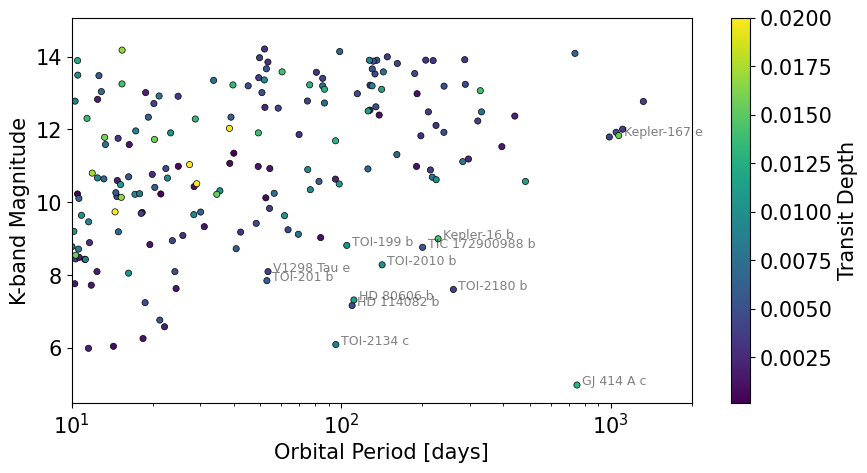

In [4]:
c = (0.102763*planet_pop['pl_radj'] / planet_pop['st_rad'])**2
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plot = ax.scatter(planet_pop['pl_orbper'],planet_pop['sy_kmag'],c=c,s=20,cmap='viridis',edgecolors='k',linewidths=0.5,vmax=0.02)
ax.set_xscale('log')
ax.set_xlim(10,2000)
plt.colorbar(plot,label='Transit Depth')

ax.set_xlabel('Orbital Period [days]')
ax.set_ylabel('K-band Magnitude')
for i in range(0,len(planet_pop)):
    if planet_pop['pl_name'][i] == 'Kepler-167 e':
        ax.annotate(planet_pop['pl_name'][i],(planet_pop['pl_orbper'][i],planet_pop['sy_kmag'][i]), fontsize=9,alpha=0.5,textcoords='offset pixels',xytext=(5,0))
    if planet_pop['pl_orbper'][i] > 50 and planet_pop['sy_kmag'][i] < 9:
        ax.annotate(planet_pop['pl_name'][i],(planet_pop['pl_orbper'][i],planet_pop['sy_kmag'][i]), fontsize=9,alpha=0.5,textcoords='offset pixels',xytext=(5,0))
plt.savefig('param_space.png',dpi=300)


 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number 

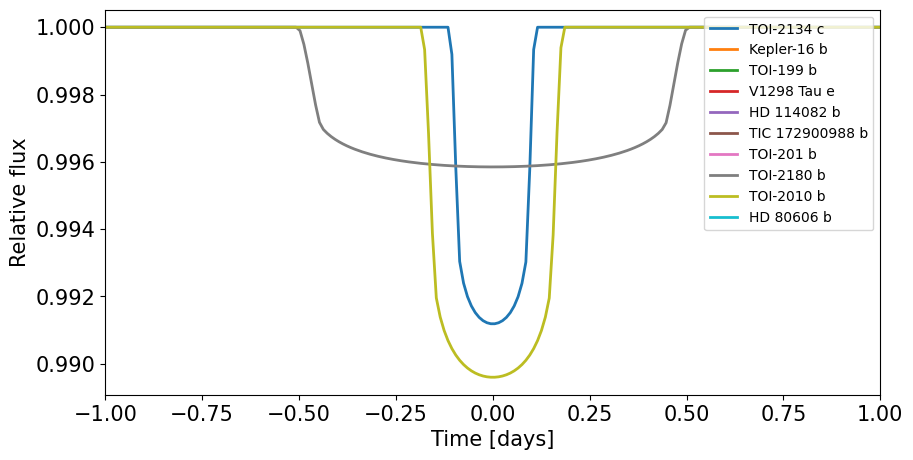

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
index_list = {}
for i in range(len(planet_pop)):
        if planet_pop['pl_orbper'][i] > 50 and planet_pop['sy_kmag'][i] < 9 and planet_pop['pl_orbper'][i] < 300:
                params = {'period':planet_pop['pl_orbper'][i],
                        'radius':(0.102763*planet_pop['pl_radj'][i] / planet_pop['st_rad'][i]),
                        'u':jnp.array([0.3,0.2]),
                        'f':0.1,
                        'bo':planet_pop['pl_imppar'][i],
                        'theta':0.6,
                        'duration':planet_pop['pl_trandur'][i]/24,
                }
                index_list[planet_pop['pl_name'][i]] = [i,params]

                # The light curve calculation requires an orbit

                t = jnp.linspace(-1.0, 1.0, 200)
                lc = oblate_lightcurve(params,t)

                ax.plot(t, lc, lw=2,label = planet_pop['pl_name'][i])
                ax.set_ylabel("Relative flux")
                ax.set_xlabel("Time [days]")
plt.legend(loc='upper right',fontsize=10)
_ = plt.xlim(t.min(), t.max())

In [9]:
full_index_list = {}
for i in range(len(planet_pop)):
        if planet_pop['pl_orbper'][i] > 50 and planet_pop['sy_kmag'][i] < 13:
                params = {'period':planet_pop['pl_orbper'][i],
                        'radius':(0.102763*planet_pop['pl_radj'][i] / planet_pop['st_rad'][i]),
                        'u':jnp.array([0.3,0.2]),
                        'f':0.1,
                        'bo':planet_pop['pl_imppar'][i],
                        'theta':0.6,
                        'duration':planet_pop['pl_trandur'][i]/24,
                }
                full_index_list[planet_pop['pl_name'][i]] = params


In [13]:
pd.DataFrame(full_index_list).T.to_csv('planet_params_full.csv',index_label='Target')
